## Build Data

In [193]:
import nfl_data_py.nfl_data_py as nfl
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('chained_assignment',None)
pd.set_option('display.max_columns',None)


def get_pbp_data(years,overwrite=False):
    """
    Pull data from nflFastR's Github repo. 
    If you choose to overwrite, it will replace the existing pbp data with the data you pull.

    """
    pbp = nfl.import_pbp_data(years)
    pbp['TOP_seconds'] = pbp['drive_time_of_possession'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if pd.notnull(x) else 0)
    
    if overwrite:
        pbp.to_csv('pbp.csv')

    return pbp


def build_gbg_data(update_seasons=[]):
    """
    Using pbp.csv, build a game-by-game dataset to use for prediction models.
    Populate update_seasons with the current year to only update this season's data while preserving historical data.

    """
    print('Loading play-by-play data.')
    pbp = pd.read_csv('pbp.csv', index_col=0, low_memory=False)
    game_date_dict = dict(pbp[['game_id','game_date']].values)

    if update_seasons:
        print('Getting data for', update_seasons)
        pbp = get_pbp_data(update_seasons)

    teams = pbp['home_team'].unique()
    seasons = pbp['season'].unique()
    
    print('Building game-by-game data.')
    data = pd.DataFrame()
    for season in seasons:
        print(season)
        for team_name in tqdm(teams):
            # create features
            team = pbp.loc[((pbp['home_team']==team_name) | (pbp['away_team']==team_name)) & (pbp['season']==season)] 
            team['GP'] = team['week']
            team['W'] = [1 if r>0 and team_name==h else 1 if r<0 and team_name==a else 0 for r,a,h in team[['result','away_team','home_team']].values]
            team['L'] = [0 if r>0 and team_name==h else 0 if r<0 and team_name==a else 1 for r,a,h in team[['result','away_team','home_team']].values]
            team['W_PCT'] = team['W']/team['GP']
            team['TOP'] = [t if team_name==p else 0 for t,p in team[['TOP_seconds','posteam']].values]
            team['FGA'] = [1 if team_name==p and f==1 else 0 for p,f in team[['posteam','field_goal_attempt']].values]
            team['FGM'] = [1 if team_name==p and f=='made' else 0 for p,f in team[['posteam','field_goal_result']].values]
            team['FG_PCT'] = team['FGM']/team['FGA']
            team['PassTD'] = np.where((team['posteam'] == team_name) & (team['pass_touchdown'] == 1), 1, 0)
            team['RushTD'] = np.where((team['posteam'] == team_name) & (team['rush_touchdown'] == 1), 1, 0)
            team['PassTD_Allowed'] = np.where((team['defteam'] == team_name) & (team['pass_touchdown'] == 1), 1, 0)
            team['RushTD_Allowed'] = np.where((team['defteam'] == team_name) & (team['rush_touchdown'] == 1), 1, 0)
            team['PassYds'] = [y if p==team_name else 0 for p,y in team[['posteam','passing_yards']].values]
            team['RushYds'] = [y if p==team_name else 0 for p,y in team[['posteam','rushing_yards']].values]
            team['PassYds_Allowed'] = [y if d==team_name else 0 for d,y in team[['defteam','passing_yards']].values]
            team['RushYds_Allowed'] = [y if d==team_name else 0 for d,y in team[['defteam','rushing_yards']].values]
            team['Fum'] = np.where((team['defteam'] == team_name) & (team['fumble_lost'] == 1), 1, 0)
            team['Fum_Allowed'] = np.where((team['posteam'] == team_name) & (team['fumble_lost'] == 1), 1, 0)
            team['INT'] = np.where((team['defteam'] == team_name) & (team['interception'] == 1), 1, 0)
            team['INT_Allowed'] = np.where((team['posteam'] == team_name) & (team['interception'] == 1), 1, 0)
            team['Sacks'] = np.where((team['defteam'] == team_name) & (team['sack'] == 1), 1, 0)
            team['Sacks_Allowed'] = np.where((team['posteam'] == team_name) & (team['sack'] == 1), 1, 0)
            team['Penalties'] = np.where((team['penalty_team'] == team_name), 1, 0)
            team['FirstDowns'] = [1 if team_name==p and f==1 else 0 for p,f in team[['posteam','first_down']].values]
            team['3rdDownConverted'] = [1 if p==team_name and t==1 else 0 for p,t in team[['posteam','third_down_converted']].values]
            team['3rdDownFailed'] = [1 if p==team_name and t==1 else 0 for p,t in team[['posteam','third_down_failed']].values]
            team['3rdDownAllowed'] = [1 if d==team_name and t==1 else 0 for d,t in team[['defteam','third_down_converted']].values]
            team['3rdDownDefended'] = [1 if d==team_name and t==1 else 0 for d,t in team[['defteam','third_down_failed']].values]
            team['PTS'] = [ap if at==team_name else hp if ht==team_name else None for ht,at,hp,ap in team[['home_team','away_team','home_score','away_score']].values]
            team['PointDiff'] = [r if team_name==h else -r if team_name==a else 0 for r,a,h in team[['result','away_team','home_team']].values]

            # aggregate from play-by-play to game-by-game
            features = {
                'GP':'mean',
                'W':'mean',
                'L':'mean',
                'W_PCT':'mean',
                'TOP':'sum',
                'FGA':'sum',
                'FGM':'sum',
                'FG_PCT':'mean',
                'PassTD':'sum',
                'RushTD':'sum',
                'PassTD_Allowed':'sum',
                'RushTD_Allowed':'sum',
                'PassYds':'sum',
                'RushYds':'sum',
                'PassYds_Allowed':'sum',
                'RushYds_Allowed':'sum',
                'Fum':'sum',
                'Fum_Allowed':'sum',
                'INT':'sum',
                'INT_Allowed':'sum',
                'Sacks':'sum',
                'Sacks_Allowed':'sum',
                'Penalties':'sum',
                'FirstDowns':'sum',
                '3rdDownConverted':'sum',
                '3rdDownFailed':'sum',
                '3rdDownAllowed':'sum',
                '3rdDownDefended':'sum',
                'PTS':'mean',
                'PointDiff':'mean'
            }

            game = team.groupby('game_id').agg(features).reset_index()
            game[['W','L']] = game[['W','L']].expanding().sum()
            game[game.columns[4:]] = game[game.columns[4:]].expanding().mean()
            game[game.columns[1:]] = game[game.columns[1:]].shift()
            game['TEAM'] = team_name
            game['Season'] = season

            data = pd.concat([data,game])

    # get rank data for each feature
    #feature_columns = list(features.keys())
    #for col in feature_columns:
    #    rank_col = f"{col}_Rank"
    #    data[rank_col] = data.groupby(['Season', 'GP', 'TEAM'])[col].rank(ascending=False)

    # separate home and away data and merge
    data = data.merge(pbp[['game_id','home_team','away_team']].drop_duplicates())
    home = data.loc[data['home_team']==data['TEAM']]
    away = data.loc[data['away_team']==data['TEAM']]
    away.columns = [f'{i}.Away' for i in away.columns]
    gbg = home.merge(away,left_on='game_id',right_on='game_id.Away')
    gbg.drop(columns=['TEAM','TEAM.Away','home_team.Away','away_team.Away','Season.Away','game_id.Away'], inplace=True)
    gbg['game_date'] = gbg['game_id'].map(game_date_dict)

    if update_seasons:
        old = pd.read_csv('gbg.csv', index_col=0, low_memory=False)
        old = old.loc[~old['Season'].isin(seasons)]
        gbg = pd.concat([old,gbg])

    gbg.to_csv('gbg.csv')


def add_odds_data():
    """
    Get odds from Australian Sports Betting's free online dataset and merge it with game-by-game data.

    """
    # load gbg data
    gbg = pd.read_csv('gbg.csv', index_col=0)
    
    # get team abbreviations
    team_descriptions = nfl.import_team_desc()
    team_abbreviation_dict = dict(team_descriptions[['team_name','team_abbr']].values)
    
    # get odds
    odds = pd.read_excel('https://www.aussportsbetting.com/historical_data/nfl.xlsx')
    odds['Home Team'] = odds['Home Team'].str.replace('Washington Redskins','Washington Commanders').str.replace('Washington Football Team','Washington Commanders')
    odds['Away Team'] = odds['Away Team'].str.replace('Washington Redskins','Washington Commanders').str.replace('Washington Football Team','Washington Commanders')
    odds['Season'] = [i.year if i.month in [8,9,10,11,12] else i.year-1 for i in odds['Date']]
    odds['Home Team Abbrev'] = odds['Home Team'].map(team_abbreviation_dict)
    odds['Away Team Abbrev'] = odds['Away Team'].map(team_abbreviation_dict)
    odds = odds[['Date','Home Score','Away Score','Home Team Abbrev','Away Team Abbrev','Home Odds Close','Away Odds Close','Total Score Close']]
    odds['Key'] = odds['Date'].astype(str) + odds['Home Team Abbrev'] + odds['Away Team Abbrev']
    odds = odds.drop(columns=['Date','Home Team Abbrev','Away Team Abbrev']).dropna()
    odds['Home Odds'] = [round((i-1)*100) if i>= 2 else round(-100/(i-1)) for i in odds['Home Odds Close']]
    odds['Away Odds'] = [round((i-1)*100) if i>= 2 else round(-100/(i-1)) for i in odds['Away Odds Close']]
    odds['Home Winnings'] = [ho-1 if h>a else -1 if a>h else 0 for ho,h,a in odds[['Home Odds Close','Home Score','Away Score']].values]
    odds['Away Winnings'] = [ao-1 if a>h else -1 if h>a else 0 for ao,h,a in odds[['Away Odds Close','Home Score','Away Score']].values]

    # merge with gbg
    gbg['Key'] = gbg['game_date'].astype(str) + gbg['home_team'] + gbg['away_team']
    gbg_and_odds = gbg.merge(odds, left_on='Key', right_on='Key')
    gbg_and_odds['Home-Team-Win'] = (gbg_and_odds['Home Score']>gbg_and_odds['Away Score']).astype(int)
    gbg_and_odds['Over'] = ((gbg_and_odds['Home Score'] + gbg_and_odds['Away Score'])>gbg_and_odds['Total Score Close']).astype(int)
    gbg_and_odds.to_csv('gbg_and_odds.csv')

## ML

In [196]:
import xgboost as xgb
import pickle as pkl
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

data = pd.read_csv('gbg_and_odds.csv', index_col=0).dropna()

margin = data['Home-Team-Win']
data.drop(columns=['Home-Team-Win','Over','Season','home_team','away_team','game_date','Key','Home Score','Away Score','Home Odds Close','Away Odds Close','Home Winnings','Away Winnings'], inplace=True)

acc_results = []
for x in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(data, margin, test_size=.1)

    train_games = X_train['game_id']
    test_games = X_test['game_id']

    X_train.drop(columns=['game_id'], inplace=True)
    X_test.drop(columns=['game_id'], inplace=True)

    train = xgb.DMatrix(X_train.astype(float).values, label=y_train)
    test = xgb.DMatrix(X_test.astype(float).values, label=y_test)

    param = {
        'max_depth': 2,
        'eta': 0.01,
        'objective': 'multi:softprob',
        'num_class': 2
    }
    epochs = 500

    model = xgb.train(param, train, epochs)
    predictions = model.predict(test)
    y = []
    for z in predictions:
        y.append(np.argmax(z))

    acc = round(accuracy_score(y_test, y)*100, 1)
    acc_results.append(acc)
    clear_output(wait=True)
    print(f"Best accuracy: {max(acc_results)}%")

    # only save results if they are the best so far
    if acc == max(acc_results):
        with open('train_games_ML.pkl','wb') as f:
            pkl.dump(train_games,f)
        with open('test_games_ML.pkl','wb') as f:
            pkl.dump(test_games,f)
        model.save_model(f'models/xgboost_ML_{acc}%.json')

print('Done')

100%|██████████| 100/100 [01:15<00:00,  1.33it/s]

Best accuracy: 75.4%
Done


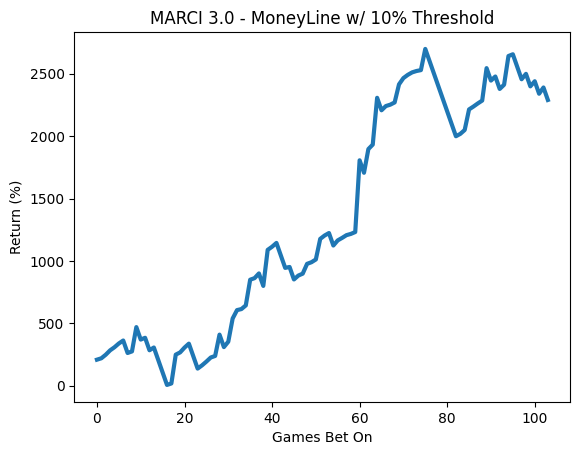

In [203]:
import xgboost as xgb
xgb_ml = xgb.Booster()
xgb_ml.load_model('models/xgboost_ML_75.4%.json')

with open('test_games_ML.pkl','rb') as f:
    test_games = pkl.load(f).tolist()

gbg_and_odds = pd.read_csv('gbg_and_odds.csv', index_col=0)
test_data = gbg_and_odds.loc[gbg_and_odds['game_id'].isin(test_games)]
test_data_matrix = xgb.DMatrix(test_data.drop(columns=['game_id','Over','Home-Team-Win','Season','home_team','away_team','game_date','Key','Home Score','Away Score','Home Odds Close','Away Odds Close','Home Winnings','Away Winnings']).astype(float).values)

predicted_probas = xgb_ml.predict(test_data_matrix)
predictions = np.argmax(predicted_probas, axis=1)
test_data['predicted_proba'] = [i[1] for i in predicted_probas]
test_data['prediction'] = (test_data['predicted_proba']>0.5).astype(int)
test_data['correct'] = test_data['Home-Team-Win']==test_data['prediction']
test_data['home_ev'] = [((h-1)*p)+((-1)*p-1) for h,a,p in test_data[['Home Odds Close','Away Odds Close','predicted_proba']].values]
test_data['away_ev'] = [((-1)*p)+((a-1)*p-1) for h,a,p in test_data[['Home Odds Close','Away Odds Close','predicted_proba']].values]

bets = test_data.loc[(test_data['predicted_proba']>0.6) | (test_data['predicted_proba']<0.4)]
bets['winnings'] = [h if he>ae else a for h,a,he,ae in bets[['Home Winnings','Away Winnings','home_ev','away_ev']].values]
bets['winnings'] = [h if c else a for h,a,c in bets[['Home Winnings','Away Winnings','correct']].values]

import matplotlib.pyplot as plt
plt.plot(bets['winnings'].cumsum().values*100, linewidth=3)
plt.title('MARCI 3.0 - MoneyLine w/ 10% Threshold')
plt.xlabel('Games Bet On')
plt.ylabel('Return (%)')
plt.show()

## OU

In [204]:
import xgboost as xgb
import pickle as pkl
from IPython.display import clear_output
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

data = pd.read_csv('gbg_and_odds.csv', index_col=0).dropna()

OU = data['Over']
data.drop(columns=['Home-Team-Win','Over','Season','home_team','away_team','game_date','Key','Home Score','Away Score','Home Odds Close','Away Odds Close','Home Winnings','Away Winnings'], inplace=True)

acc_results = []

for x in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(data, OU, test_size=.1)

    train_games = X_train['game_id']
    test_games = X_test['game_id']

    X_train.drop(columns=['game_id'], inplace=True)
    X_test.drop(columns=['game_id'], inplace=True)

    train = xgb.DMatrix(X_train.astype(float).values, label=y_train)
    test = xgb.DMatrix(X_test.astype(float).values, label=y_test)

    param = {
        'max_depth': 6,
        'eta': 0.05,
        'objective': 'multi:softprob',
        'num_class': 3
    }
    epochs = 300

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)
    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(accuracy_score(y_test, y)*100, 1)
    acc_results.append(acc)
    clear_output(wait=True)
    print(f"Best accuracy: {max(acc_results)}%")
    
    # only save results if they are the best so far
    if acc == max(acc_results):
        with open('train_games_OU.pkl','wb') as f:
            pkl.dump(train_games,f)
        with open('test_games_OU.pkl','wb') as f:
            pkl.dump(test_games,f)
        model.save_model(f'models/xgboost_OU_{acc}%.json')

100%|██████████| 100/100 [02:17<00:00,  1.37s/it]

Best accuracy: 59.3%


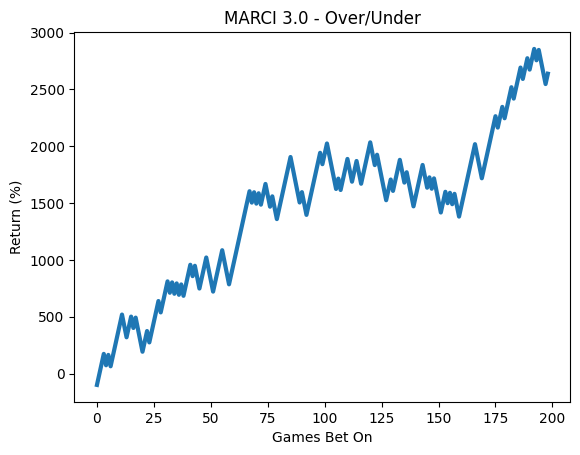

In [207]:
import xgboost as xgb
xgb_ou = xgb.Booster()
xgb_ou.load_model('models/xgboost_OU_59.3%.json')

with open('test_games_OU.pkl','rb') as f:
    test_games = pkl.load(f).tolist()

gbg_and_odds = pd.read_csv('gbg_and_odds.csv', index_col=0)
test_data = gbg_and_odds.loc[gbg_and_odds['game_id'].isin(test_games)]
test_data_matrix = xgb.DMatrix(test_data.drop(columns=['game_id','Over','Home-Team-Win','Season','home_team','away_team','game_date','Key','Home Score','Away Score','Home Odds Close','Away Odds Close','Home Winnings','Away Winnings']).astype(float).values)

predicted_probas = xgb_ou.predict(test_data_matrix)
predictions = np.argmax(predicted_probas, axis=1)
test_data['predicted_proba'] = [i[1] for i in predicted_probas]
test_data['prediction'] = (test_data['predicted_proba']>0.5).astype(int)
test_data['correct'] = test_data['Over']==test_data['prediction']

bets = test_data
bets['winnings'] = [0.91 if c else -1 for c in bets[['correct']].values]

import matplotlib.pyplot as plt
plt.plot(bets['winnings'].cumsum().values*100, linewidth=3)
plt.title('MARCI 3.0 - Over/Under')
plt.xlabel('Games Bet On')
plt.ylabel('Return (%)')
plt.show()

## Predict

In [321]:
url = 'https://www.nbcsports.com/nfl/schedule'
df = pd.read_html(url)[0]
df['Away Team'] = [' '.join(i.split('\xa0')[1:]) for i in df['Away TeamAway Team']]
df['Home Team'] = [' '.join(i.split('\xa0')[1:]) for i in df['Home TeamHome Team']]
df['Date'] = pd.to_datetime(df['Game TimeGame Time'])
df['Date'] = df['Date'].dt.strftime('%A %m/%d %I:%M %p')
df['Date'] = df['Date'].apply(lambda x: f"{x.split()[0]} {int(x.split()[1].split('/')[1])}/{int(x.split()[1].split('/')[0])} {x.split()[2]}".capitalize())

return df[['Away Team','Home Team','Date']]

C:\Users\Brayden\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


,Away TeamAway Team,Home TeamHome Team,Game TimeGame Time,NetworkNetwork,VenueVenue,Away Team,Home Team,Date
0,DET Detroit Lions,KC Kansas City Chiefs,09/07/23 8:20 PM EST,NBC,GEHA Field at Arrowhead Stadium,Detroit Lions,Kansas City Chiefs,Thursday 7/9 08:20
1,CIN Cincinnati Bengals,CLE Cleveland Browns,09/10/23 1:00 PM EST,CBS,Cleveland Browns Stadium,Cincinnati Bengals,Cleveland Browns,Sunday 10/9 01:00
2,Jax Jacksonville Jaguars,IND Indianapolis Colts,09/10/23 1:00 PM EST,FOX,Lucas Oil Stadium,Jacksonville Jaguars,Indianapolis Colts,Sunday 10/9 01:00
3,TB Tampa Bay Buccaneers,MIN Minnesota Vikings,09/10/23 1:00 PM EST,CBS,U.S. Bank Stadium,Tampa Bay Buccaneers,Minnesota Vikings,Sunday 10/9 01:00
4,TEN Tennessee Titans,NO New Orleans Saints,09/10/23 1:00 PM EST,CBS,Caesars Superdome,Tennessee Titans,New Orleans Saints,Sunday 10/9 01:00
5,CAR Carolina Panthers,ATL Atlanta Falcons,09/10/23 1:00 PM EST,FOX,Mercedes-Benz Stadium,Carolina Panthers,Atlanta Falcons,Sunday 10/9 01:00
6,HOU Houston Texans,BAL Baltimore Ravens,09/10/23 1:00 PM EST,CBS,M&T Bank Stadium,Houston Texans,Baltimore Ravens,Sunday 10/9 01:00
7,SF San Francisco 49ers,PIT Pittsburgh Steelers,09/10/23 1:00 PM EST,FOX,Acrisure Stadium,San Francisco 49ers,Pittsburgh Steelers,Sunday 10/9 01:00
8,ARI Arizona Cardinals,WAS Washington Commanders,09/10/23 1:00 PM EST,FOX,FedEx Field,Arizona Cardinals,Washington Commanders,Sunday 10/9 01:00
9,GB Green Bay Packers,CHI Chicago Bears,09/10/23 4:25 PM EST,FOX,Soldier Field,Green Bay Packers,Chicago Bears,Sunday 10/9 04:25


In [243]:
pbp = pd.read_csv('Data/pbp_this_year.csv')

C:\Users\Brayden\AppData\Local\Temp\ipykernel_21628\2050820634.py:1: DtypeWarning: Columns (181,182,184,185,191,192,195,196,199,200,205,206,207,208,220,221,222,224,226,228,245,246,247,255,256,257,262,264,265,285,286,303) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv('Data/pbp_this_year.csv')


In [314]:
import os
current_directory = os.path.dirname('')
parent_directory = os.path.dirname(current_directory)
data_directory = os.path.join(parent_directory, 'Data')
model_directory = os.path.join(parent_directory, 'Models')

file_path = os.path.join(data_directory, f'pbp_this_year.csv')
pbp = pd.read_csv(file_path)

def get_one_week(team_name,season,week):
    # create columns
    team = pbp.loc[((pbp['home_team']==team_name) | (pbp['away_team']==team_name)) & (pbp['season']==season)] 
    team['GP'] = team['week']
    team['W'] = [1 if r>0 and team_name==h else 1 if r<0 and team_name==a else 0 for r,a,h in team[['result','away_team','home_team']].values]
    team['L'] = [0 if r>0 and team_name==h else 0 if r<0 and team_name==a else 1 for r,a,h in team[['result','away_team','home_team']].values]
    team['W_PCT'] = team['W']/team['GP']
    team['TOP'] = [t if team_name==p else 0 for t,p in team[['TOP_seconds','posteam']].values]
    team['FGA'] = [1 if team_name==p and f==1 else 0 for p,f in team[['posteam','field_goal_attempt']].values]
    team['FGM'] = [1 if team_name==p and f=='made' else 0 for p,f in team[['posteam','field_goal_result']].values]
    team['FG_PCT'] = team['FGM']/team['FGA']
    team['PassTD'] = np.where((team['posteam'] == team_name) & (team['pass_touchdown'] == 1), 1, 0)
    team['RushTD'] = np.where((team['posteam'] == team_name) & (team['rush_touchdown'] == 1), 1, 0)
    team['PassTD_Allowed'] = np.where((team['defteam'] == team_name) & (team['pass_touchdown'] == 1), 1, 0)
    team['RushTD_Allowed'] = np.where((team['defteam'] == team_name) & (team['rush_touchdown'] == 1), 1, 0)
    team['PassYds'] = [y if p==team_name else 0 for p,y in team[['posteam','passing_yards']].values]
    team['RushYds'] = [y if p==team_name else 0 for p,y in team[['posteam','rushing_yards']].values]
    team['PassYds_Allowed'] = [y if d==team_name else 0 for d,y in team[['defteam','passing_yards']].values]
    team['RushYds_Allowed'] = [y if d==team_name else 0 for d,y in team[['defteam','rushing_yards']].values]
    team['Fum'] = np.where((team['defteam'] == team_name) & (team['fumble_lost'] == 1), 1, 0)
    team['Fum_Allowed'] = np.where((team['posteam'] == team_name) & (team['fumble_lost'] == 1), 1, 0)
    team['INT'] = np.where((team['defteam'] == team_name) & (team['interception'] == 1), 1, 0)
    team['INT_Allowed'] = np.where((team['posteam'] == team_name) & (team['interception'] == 1), 1, 0)
    team['Sacks'] = np.where((team['defteam'] == team_name) & (team['sack'] == 1), 1, 0)
    team['Sacks_Allowed'] = np.where((team['posteam'] == team_name) & (team['sack'] == 1), 1, 0)
    team['Penalties'] = np.where((team['penalty_team'] == team_name), 1, 0)
    team['FirstDowns'] = [1 if team_name==p and f==1 else 0 for p,f in team[['posteam','first_down']].values]
    team['3rdDownConverted'] = [1 if p==team_name and t==1 else 0 for p,t in team[['posteam','third_down_converted']].values]
    team['3rdDownFailed'] = [1 if p==team_name and t==1 else 0 for p,t in team[['posteam','third_down_failed']].values]
    team['3rdDownAllowed'] = [1 if d==team_name and t==1 else 0 for d,t in team[['defteam','third_down_converted']].values]
    team['3rdDownDefended'] = [1 if d==team_name and t==1 else 0 for d,t in team[['defteam','third_down_failed']].values]
    team['PTS'] = [ap if at==team_name else hp if ht==team_name else None for ht,at,hp,ap in team[['home_team','away_team','home_score','away_score']].values]
    team['PointDiff'] = [r if team_name==h else -r if team_name==a else 0 for r,a,h in team[['result','away_team','home_team']].values]

    # aggregate from play-by-play to game-by-game
    features = {
        'GP':'mean',
        'W':'mean',
        'L':'mean',
        'W_PCT':'mean',
        'TOP':'sum',
        'FGA':'sum',
        'FGM':'sum',
        'FG_PCT':'mean',
        'PassTD':'sum',
        'RushTD':'sum',
        'PassTD_Allowed':'sum',
        'RushTD_Allowed':'sum',
        'PassYds':'sum',
        'RushYds':'sum',
        'PassYds_Allowed':'sum',
        'RushYds_Allowed':'sum',
        'Fum':'sum',
        'Fum_Allowed':'sum',
        'INT':'sum',
        'INT_Allowed':'sum',
        'Sacks':'sum',
        'Sacks_Allowed':'sum',
        'Penalties':'sum',
        'FirstDowns':'sum',
        '3rdDownConverted':'sum',
        '3rdDownFailed':'sum',
        '3rdDownAllowed':'sum',
        '3rdDownDefended':'sum',
        'PTS':'mean',
        'PointDiff':'mean'
    }

    game = team.groupby('game_id').agg(features).reset_index()
    game[['W','L']] = game[['W','L']].expanding().sum()
    game[game.columns[4:]] = game[game.columns[4:]].expanding().mean()
    game['TEAM'] = team_name
    game['Season'] = season
    return game.loc[game['GP']==week]


def get_one_week_home_and_away(home,away,season,week):
    home = get_one_week(home,season,week)
    away = get_one_week(away,season,week)
    away.columns = [f'{i}.Away' for i in away.columns]
    gbg = home.merge(away,left_index=True,right_index=True)
    gbg.drop(columns=['TEAM','TEAM.Away','Season.Away','game_id.Away'], inplace=True)
    return gbg


def predict(home,away,season,week,total,home_odds,away_odds):
    # finish preparing data
    gbg = get_one_week_home_and_away(home,away,season,week)
    gbg['Total Score Close'] = total
    gbg['Home Odds'] = home_odds
    gbg['Away Odds'] = away_odds
    matrix = xgb.DMatrix(gbg.drop(columns=['game_id','Season']).astype(float).values)

    # moneyline
    model = 'xgboost_ML_75.4%'
    file_path = os.path.join(model_directory, f'{model}.json')
    xgb_ml = xgb.Booster()
    xgb_ml.load_model(file_path)
    ml_predicted_proba = xgb_ml.predict(matrix)[0][1]

    # over/under
    model = 'xgboost_OU_59.3%'
    file_path = os.path.join(model_directory, f'{model}.json')
    xgb_ou = xgb.Booster()
    xgb_ou.load_model(file_path)
    ou_predicted_proba = xgb_ou.predict(matrix)[0][1]

    # return dict
    predictions = {'Moneyline':{
                        home: ml_predicted_proba,
                        away: 1-ml_predicted_proba},
                    'Over/Under':{
                        'Over':ou_predicted_proba,
                        'Under':1-ou_predicted_proba}
                    }
    
    return predictions



C:\Users\Brayden\AppData\Local\Temp\ipykernel_21628\414576273.py:8: DtypeWarning: Columns (181,182,184,185,191,192,195,196,199,200,205,206,207,208,220,221,222,224,226,228,245,246,247,255,256,257,262,264,265,285,286,303) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv(file_path)


In [315]:
predict('PHI','KC',2022,22,51,-125,105)

{'Moneyline': {'PHI': 0.4090659, 'KC': 0.5909340977668762},
 'Over/Under': {'Over': 0.8390681, 'Under': 0.16093188524246216}}

In [5]:
import Source.Build.nfl_data_py.nfl_data_py as nfl
# get team abbreviations
team_descriptions = nfl.import_team_desc()
team_abbreviation_dict = dict(team_descriptions[['team_name','team_abbr']].values)
team_name_dict = dict(team_descriptions[['team_abbr','team_name']].values)

import pickle as pkl

with open('Source/Pickles/team_name_to_abbreviation.pkl', 'wb') as f:
    pkl.dump(team_abbreviation_dict,f)

with open('Source/Pickles/team_abbreviation_to_name.pkl', 'wb') as f:
    pkl.dump(team_name_dict,f)

In [4]:
import pickle as pkl
with open('Source/Pickles/train_games_OU.pkl', 'rb') as f:
    train_games_ML = pkl.load(f)
len(train_games_ML)


1782